In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",
                          username="root",
                          password="27104720A",
                          database="ecommerce")

cur=db.cursor()

# Basic Questions

## 1. List all unique cities where customers are located.

In [28]:
query="""select distinct customer_city from customers"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


## 2. Count the number of orders placed in 2017.

In [6]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
print('The total number of orders placed in 2017 are:',data[0][0])

The total number of orders placed in 2017 are: 45101


## 3. Find the total sales per category.

In [8]:
query="""select upper(products.product_category) as category,round(sum(payments.payment_value),2) as sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


## 4. Calculate the percentage of orders that were paid in installments.

In [11]:
query="""select round((sum(case when payment_installments>=1 then 1
else 0 end)) / count(*)*100,3) from payments;"""

cur.execute(query)
data=cur.fetchall()
print("The percentage of orders that were paid in installments is:",data[0][0],'%')

The percentage of orders that were paid in installments is: 99.998 %


## 5. Count the number of customers from each state. 

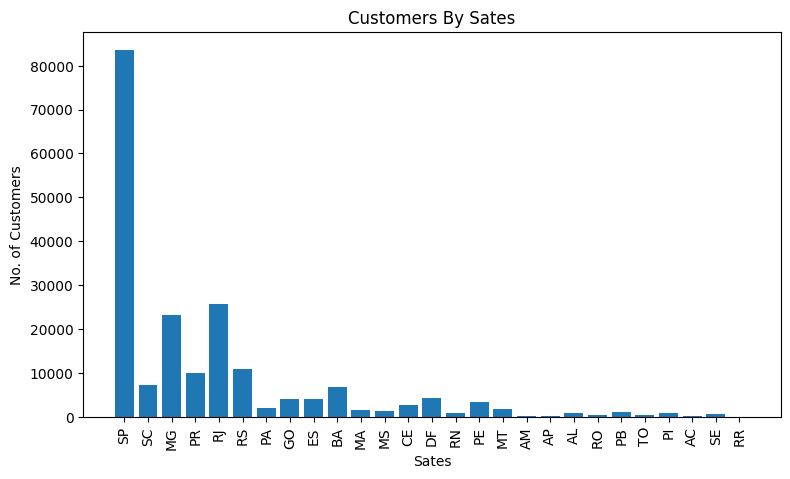

In [12]:
query="""select customer_state,count(customer_id)
from customers group by customer_state"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['State','No. of customers'])

#plotting the data
plt.figure(figsize=(9,5))
x=df['State']
y=df['No. of customers']
plt.bar(x,y)
plt.xticks(rotation='vertical')
plt.xlabel('Sates')
plt.ylabel('No. of Customers')
plt.title('Customers By Sates')
plt.show()

# Intermediate Questions

## 1. Calculate the number of orders per month in 2018.

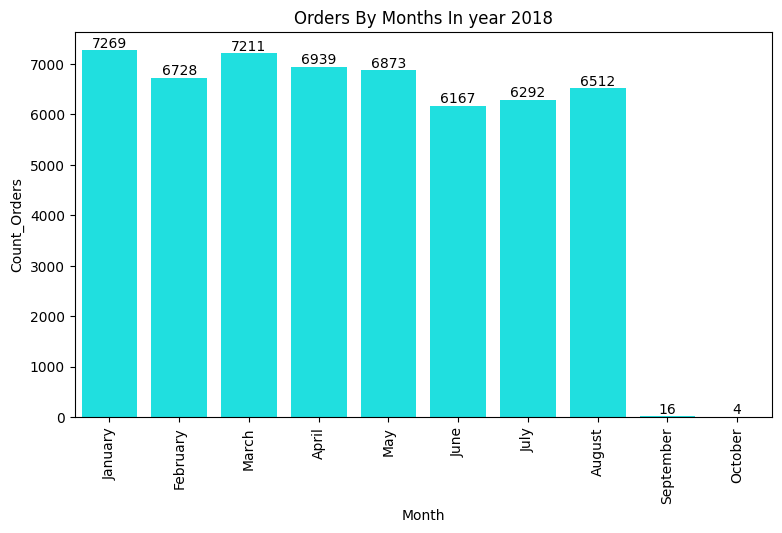

In [48]:
query="""select monthname(order_purchase_timestamp),count(order_id)
from orders where year(order_purchase_timestamp)=2018 
group by monthname(order_purchase_timestamp)"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Month','Count_Orders'])
df

#plotting the data
plt.figure(figsize=(9,5))
o=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax=sns.barplot(x=df['Month'],y=df['Count_Orders'],data=df,order=o,color='cyan')
ax.bar_label(ax.containers[0])
plt.xticks(rotation='vertical')
plt.title('Orders By Months In year 2018')
plt.show()

## 2. Find the average number of products per order, grouped by customer city.

In [53]:
query="""with count_per_order as
(select orders.order_id,orders.customer_id,
count(order_items.order_id) as OC
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)
select customers.customer_city,
round(avg(count_per_order.OC),2) as Avg_Orders from
customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by Avg_Orders desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Customer_city','Avg_Orders'])
df.head(10)

,Customer_city,Avg_Orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,curralinho,4.00
7,picarra,4.00
8,morro de sao paulo,4.00
9,teixeira soares,4.00


## 3. Calculate the percentage of total revenue contributed by each product category.

In [3]:
query="""select upper(products.product_category) as category,
round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100,2) 
as Percentage_sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
order by Percentage_sales desc;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Percentage_Sales'])
df.head()

,Category,Percentage_Sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


## 4. Identify the correlation between product price and the number of times a product has been purchased.

In [8]:
import numpy as np
query="""SELECT products.product_category,
count(order_items.product_id) as Count_orders,
round(avg(order_items.price),2) as Avg_Price
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Count_orders','Avg_Price'])

#calculating the correlation between Count_orders and Avg_Price
arr1=df['Count_orders']
arr2=df['Avg_Price']
corr=np.corrcoef([arr1,arr2])
print('The correlation between product price and \nthe number of times a product has been purchased is:\n',corr[0][1])

The correlation between product price and 
the number of times a product has been purchased is:
 -0.10631514167157562


## From here, we can conclude that there is no relation between product price and the number of times a product has been purchased

## 5. Calculate the total revenue generated by each seller, and rank them by revenue.

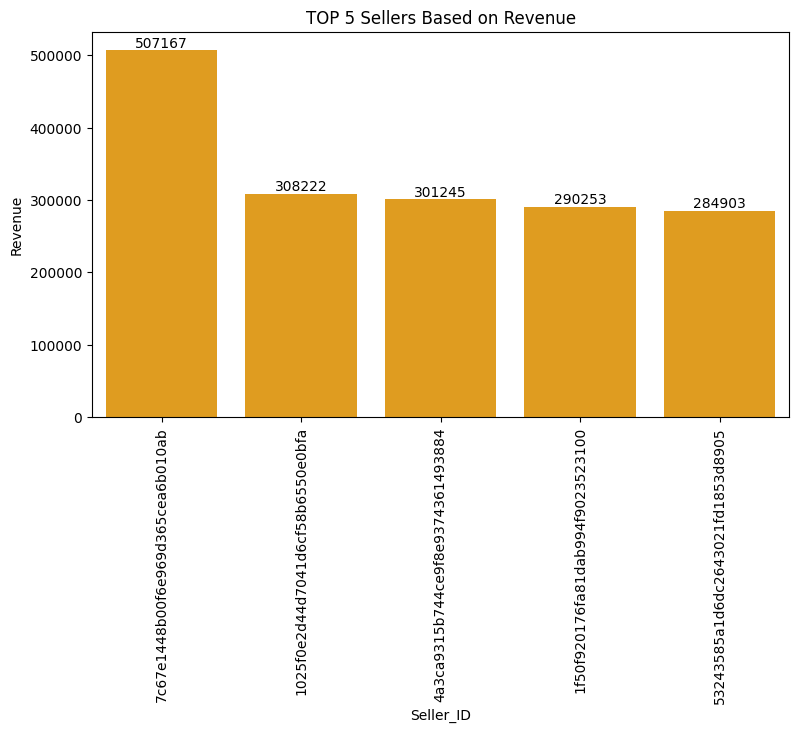

In [14]:
query="""select *, dense_rank() over(order by Revenue desc) as rnk from
(select order_items.seller_id,
round(sum(payments.payment_value),2) as Revenue from
order_items join payments
on payments.order_id=order_items.order_id
group by order_items.seller_id) as A;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Seller_ID','Revenue','Rank'])
df=df.head()

#plotting the data
plt.figure(figsize=(9,5))
ax=sns.barplot(x=df['Seller_ID'],y=df['Revenue'],data=df,color='orange')
ax.bar_label(ax.containers[0])
plt.xticks(rotation='vertical')
plt.title('TOP 5 Sellers Based on Revenue')
plt.show()

# Advanced Questions

## 1. Calculate the moving average of order values for each customer over their order history.

In [15]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as Moving_Avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment from
payments join orders
on payments.order_id=orders.order_id) as A;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Customer_id','Order_purchase_timestamp','Payments','Moving_Avg'])
df

,Customer_id,Order_purchase_timestamp,Payments,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


## 2. Calculate the cumulative sales per month for each year.

In [2]:
query="""select *, round(sum(Sales) over(order by Years,Months),2)
as Cumulative_Sales from
(select year(orders.order_purchase_timestamp) as Years,
month(orders.order_purchase_timestamp) as Months,
round(sum(payments.payment_value),2) as Sales from
orders join payments on
orders.order_id=payments.order_id
group by Years,Months
order by Years,Months) as a;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Months','Sales','Cumulative Sales'])
df

,Years,Months,Sales,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


## 3. Calculate the year-over-year growth rate of total sales.

In [3]:
query="""with b as (select *,lag(Current_Year_Sales,1) over(order by years) as 
Previous_Year_Sales from
(select year(orders.order_purchase_timestamp) as Years,
round(sum(payments.payment_value),2) as Current_Year_Sales from
orders join payments on
orders.order_id=payments.order_id
group by Years
order by Years) as a)
select Years,
round(((Current_Year_Sales-Previous_Year_Sales)/Previous_Year_Sales)*100,2)
as Year_over_Year_Growth from b;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Year_over_Year_Growth'])
df

,Years,Year_over_Year_Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


## 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [8]:
query="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order from
customers join orders on
customers.customer_id=orders.customer_id
group by customers.customer_id),

b as(select a.customer_id,
count(distinct orders.order_purchase_timestamp) as next_order
from a join orders on
a.customer_id=orders.customer_id
and first_order<orders.order_purchase_timestamp
and orders.order_purchase_timestamp<date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
as Customer_Retention_Rate
from a left join b on
a.customer_id=b.customer_id;"""

cur.execute(query)
data=cur.fetchall()
print('The retention rate of customers is:',data[0])

The retention rate of customers is: (None,)


### Since, none of the customers have repeated any purchase within 6 months, that's why our retention rate of customers is null

## 5. Identify the top 3 customers who spent the most money in each year.

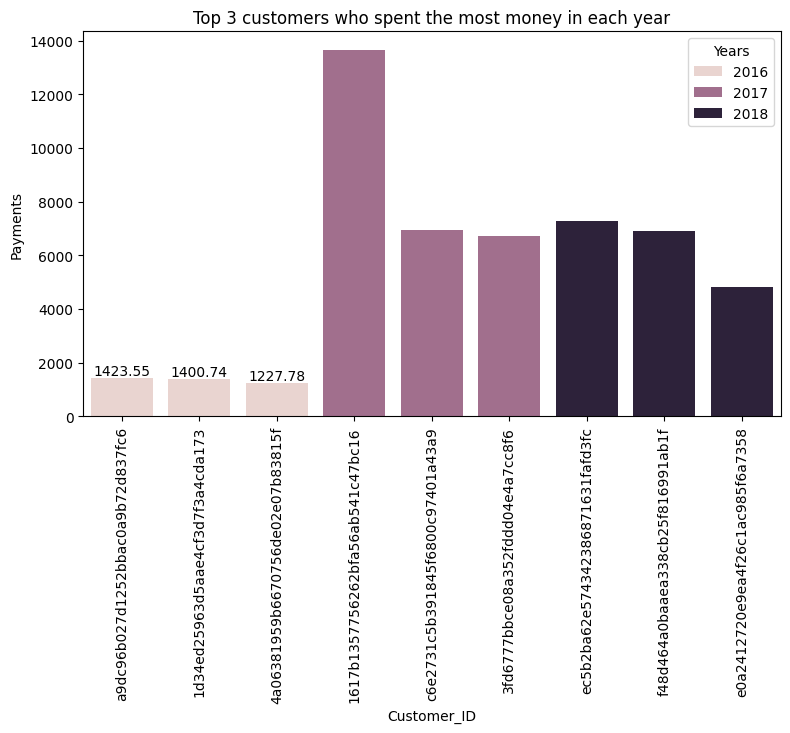

In [11]:
query="""select Years,customer_id,Payment,rnk 
from
(select year(orders.order_purchase_timestamp) as Years,
orders.order_id,
orders.customer_id,
round(sum(payments.payment_value),2) as Payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc)
as rnk from orders join payments on
orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id,orders.order_id) as a
where rnk<=3;"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Customer_ID','Payments','Rank'])

#plotting the data
plt.figure(figsize=(9,5))
ax=sns.barplot(x=df['Customer_ID'],y=df['Payments'],data=df,hue=df['Years'])
ax.bar_label(ax.containers[0])
plt.xticks(rotation='vertical')
plt.title('Top 3 customers who spent the most money in each year')
plt.show()